# Time Series EDA

In this lesson we will discuss multiple different visualizations for exploring time series data. The primary use case for Time Series EDA techniques is when we have a single continuous variable sampled over time and we want to identify **trend** and **seasonality**.

### Setup
We'll be looking at temperature data for san antonio from late 2012 to late 2017.

We'll need to convert from Kelvin to Fahrenheit.

°F = (K - 273.15) x 1.8000 + 32.00

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

In [3]:
url = "https://gist.githubusercontent.com/ryanorsinger/0ec766c66f4089bdcbc1d4fb294a3394/raw/197c1f0d7b55a45f29437811bc73d9c4ef8af647/sa_temps.csv"
df = pd.read_csv(url, index_col='datetime', parse_dates=True).sort_index()
df.temp = (df.temp - 273.15) * 1.8 + 32

print('Date Range:', df.index.min(), 'to', df.index.max())
print('Shape:', df.shape)

df.head(10)

Date Range: 2012-10-01 13:00:00 to 2017-11-30 00:00:00
Shape: (45252, 1)


,temp
datetime,
2012-10-01 13:00:00,61.052000
2012-10-01 14:00:00,61.076568
2012-10-01 15:00:00,61.139294
2012-10-01 16:00:00,61.202020
2012-10-01 17:00:00,61.264747
2012-10-01 18:00:00,61.327473
2012-10-01 19:00:00,61.390200
2012-10-01 20:00:00,61.452926
2012-10-01 21:00:00,61.515652


#### Seasonality
A repeated cycle in the data. Occurs at fixed frequency. In our weather data there is yearly and daily seasonality.

#### Trend
Long term upwards or downwards movement

#### Cycle
Some arbitrary chunk of time, usually longer than a season, or consists of multiple seasons

### Data Splitting
- Ideally all splits contain a season
- Human-based: Using domain knowledge, a cutoff is selected. (ex: use the last year as Test)
- Percentage-based: A cutoff is selected arbitrarily (ex: use the last 20% of observations as Test)
- Cross-validation-based: Break data into slices and use successive slices as train and test repeatedly

`sklearn.model_selection.TimeSeriesSplit`

### Percentage Based

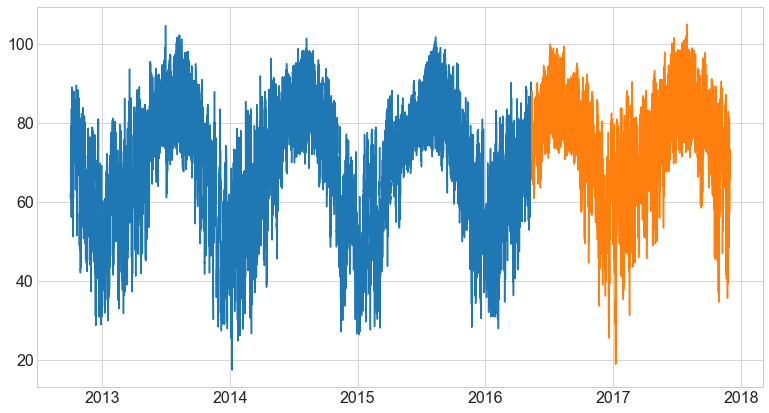

In [4]:
train_size = 0.70 # 70% train, 30% test
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # Everything up to but not including the test_start_index
test = df[test_start_index:] # Everything from the test_start_index to the end

plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)

### Human-Based

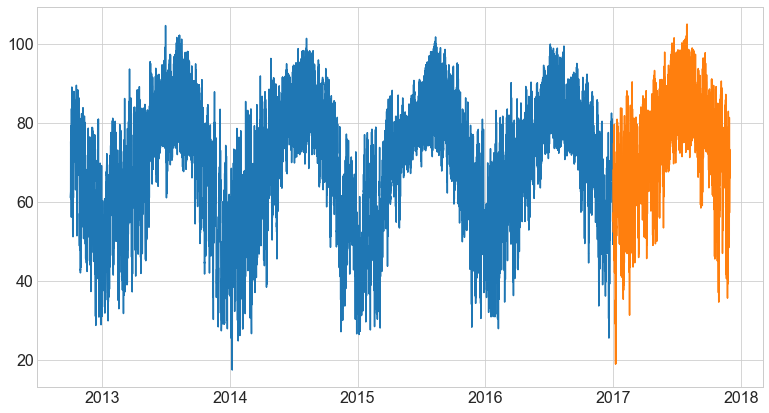

In [5]:
train = df[:'2016'] # includes 2016
test = df['2017'] 

plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)

For now, we will choose to use the data from 2017 as our test data split and explore the data up to 2017. We can choose to repeat this process to create a validate split. 

### Visualizations

Now we will discuss several techniques for time series data visualization.

We'll store our target in a variable named y for ease of access, but we will jump back and forth between our `train` DataFrame object and our `y` Series object as we see fit.

In [6]:
y = train.temp
y.head()

datetime
2012-10-01 13:00:00    61.052000
2012-10-01 14:00:00    61.076568
2012-10-01 15:00:00    61.139294
2012-10-01 16:00:00    61.202020
2012-10-01 17:00:00    61.264747
Name: temp, dtype: float64

In [7]:
y.index

DatetimeIndex(['2012-10-01 13:00:00', '2012-10-01 14:00:00',
               '2012-10-01 15:00:00', '2012-10-01 16:00:00',
               '2012-10-01 17:00:00', '2012-10-01 18:00:00',
               '2012-10-01 19:00:00', '2012-10-01 20:00:00',
               '2012-10-01 21:00:00', '2012-10-01 22:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=37259, freq=None)

### Basic Histogram (Ignoring Time Component)

<AxesSubplot:title={'center':'Distribution of Temperature'}, xlabel='Temperature in Fahrenheit', ylabel='Frequency'>

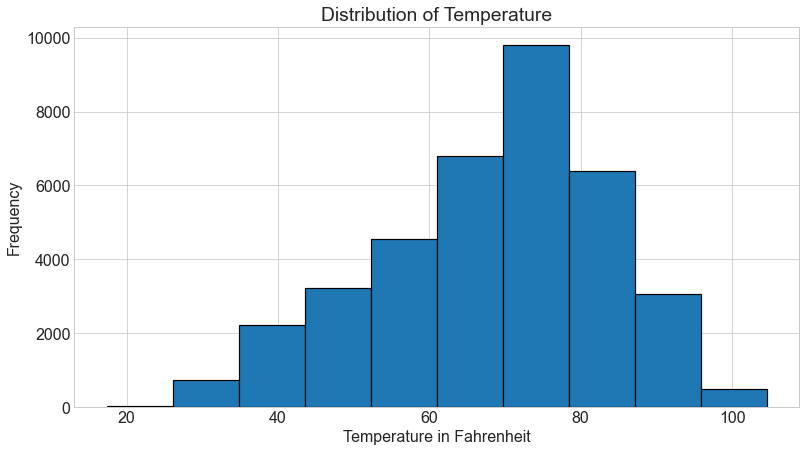

In [8]:
plt.title('Distribution of Temperature')
plt.xlabel('Temperature in Fahrenheit')
y.plot.hist(linewidth=1.2, edgecolor='black')

We can treat components of the date as separate categorical features. 

For example, what if we wanted to extract "month" from our dates and use that to group our data?

<div class="alert alert-info">
    <p><strong>Aside: Month and Weekday Ordering</strong></p>
    <p>By default, matplotlib/pandas will sort months and weekdays alphabetically, which is usually not what we want.</p>
    <p>There are several ways to work around this:</p>
    <ul>
        <li>Just use the month (1-12) number or weekday number (1-7)</li>
        <li>Instead of using just the month or weekday, use a leading number and then the name (e.g. 1-Jan, 2-Feb)</li>
        <li>Use a combination of the techniques above, and then re-index the resulting pandas object with more human friendly names</li>
        <li>Use a combination of the techniques above, and then manually adjust the labels with matplotlib</li>
    </ul>
</div>

In [9]:
# make an new column 'month'
train['month'] = train.index.strftime('%m-%b')

In [10]:
train.head()

,temp,month
datetime,,
2012-10-01 13:00:00,61.052000,10-Oct
2012-10-01 14:00:00,61.076568,10-Oct
2012-10-01 15:00:00,61.139294,10-Oct
2012-10-01 16:00:00,61.202020,10-Oct
2012-10-01 17:00:00,61.264747,10-Oct


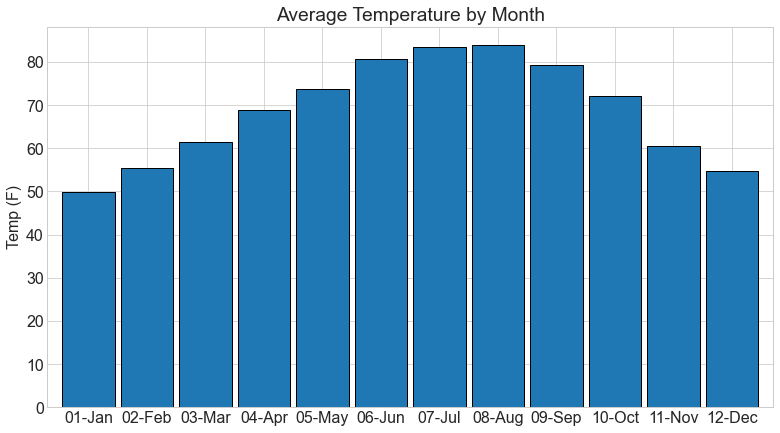

In [11]:
ax = train.groupby(train.month).temp.mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Month', xlabel='', ylabel='Temp (F)')
plt.show()

In [12]:
train.groupby('month').describe()

temp                                                       \
         count       mean        std      min        25%        50%   
month                                                                 
01-Jan  2976.0  49.831129  11.776940  17.4200  40.484750  49.352000   
02-Feb  2712.0  55.558854  12.527302  27.5582  45.353300  57.218000   
03-Mar  2976.0  61.421913  11.471243  26.6180  53.777900  62.366228   
04-Apr  2880.0  68.855211   9.407738  38.3720  63.347300  69.546815   
05-May  2976.0  73.742506   8.197797  45.0680  69.414950  74.102000   
06-Jun  2880.0  80.614231   6.423662  63.4820  75.884000  79.812500   
07-Jul  2976.0  83.449665   7.620765  60.9800  77.247500  82.238000   
08-Aug  2976.0  83.964775   7.904737  67.6040  77.428850  82.637600   
09-Sep  2880.0  79.356778   7.690668  54.3764  74.077025  78.601250   
10-Oct  3707.0  72.065809   9.829575  41.6975  65.567000  72.985100   
11-Nov  3600.0  60.545556  11.964570  27.1040  52.857500  62.096000   
12-Dec  3720.0  54.689498  11.862930  25.5020  45.950000  54.954500   

                            
              75%      max  
month                       
01-Jan  59.017550   83.084  
02-Feb  64.994000   85.334  
03-Mar  69.446360   93.542  
04-Apr  75.114500   96.224  
05-May  78.980000   95.432  
06-Jun  85.370000  104.540  
07-Jul  90.198500  101.516  
08-Aug  90.576500  102.092  
09-Sep  85.177175   98.510  
10-Oct  79.036700   95.090  
11-Nov  69.336500   87.836  
12-Dec  63.896000   83.372

<AxesSubplot:xlabel='month', ylabel='temp'>

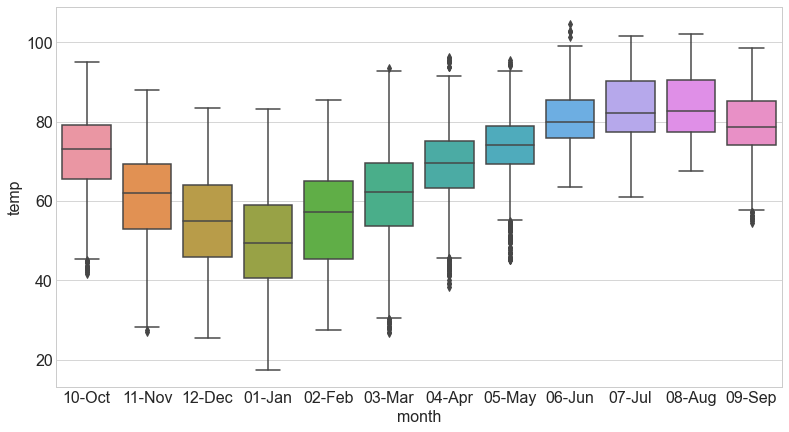

In [13]:
# boxplot for each month
sns.boxplot(data = train, x = 'month', y = 'temp')

Or we can extract weekday name from our date data:

In [14]:
train['weekday'] = train.index.day_name()

In [15]:
train.head()

,temp,month,weekday
datetime,,,
2012-10-01 13:00:00,61.052000,10-Oct,Monday
2012-10-01 14:00:00,61.076568,10-Oct,Monday
2012-10-01 15:00:00,61.139294,10-Oct,Monday
2012-10-01 16:00:00,61.202020,10-Oct,Monday
2012-10-01 17:00:00,61.264747,10-Oct,Monday


[Text(0.5, 1.0, 'Average Temperature by Day of Week')]

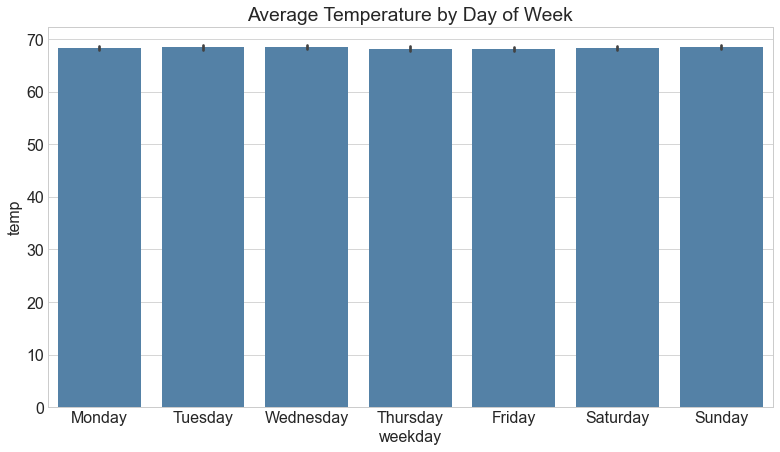

In [16]:
sns.barplot(data=train, x='weekday', y='temp', color='steelblue')\
    .set(title='Average Temperature by Day of Week')

<AxesSubplot:xlabel='weekday', ylabel='temp'>

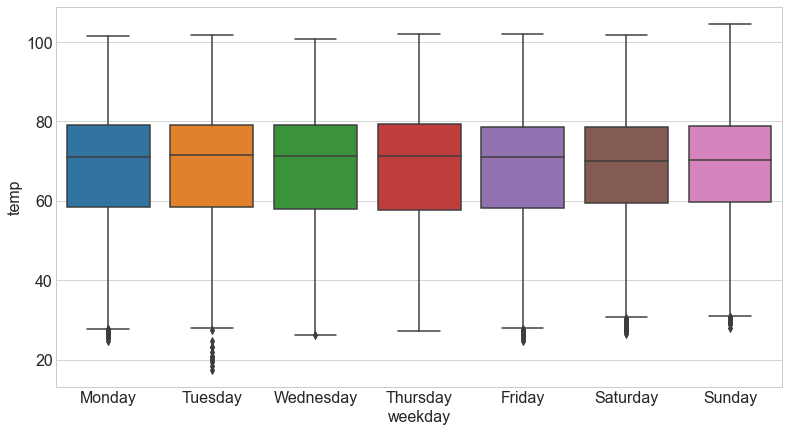

In [17]:
sns.boxplot(x = 'weekday', y = 'temp', data=train) 

### Visualizing the Target Over Time

This can be as simple as calling `.plot` on a dataframe or series with a datetime index.

<AxesSubplot:xlabel='datetime'>

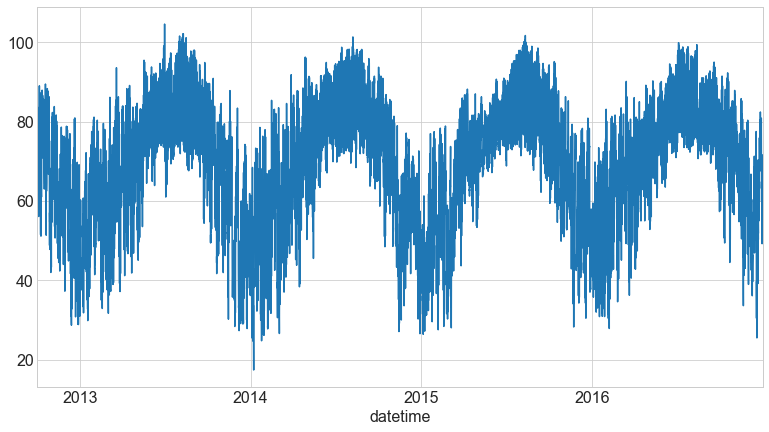

In [18]:
y.plot()

We can also resample our target and visualize it over various time periods.

<AxesSubplot:title={'center':'6 hour average'}, xlabel='datetime'>

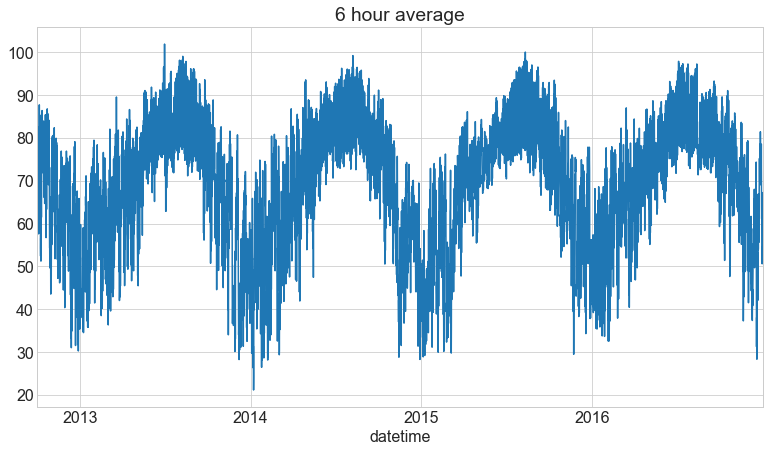

In [19]:
y.resample('6H').mean().plot(title='6 hour average')

<AxesSubplot:title={'center':'2 week average'}, xlabel='datetime'>

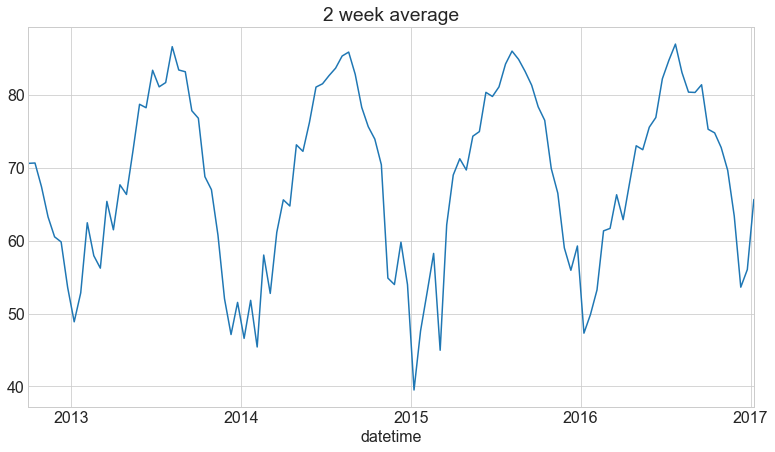

In [20]:
y.resample('2W').mean().plot(title='2 week average')

We can combine these visualizations to see how the aggregating smoothes out the data.

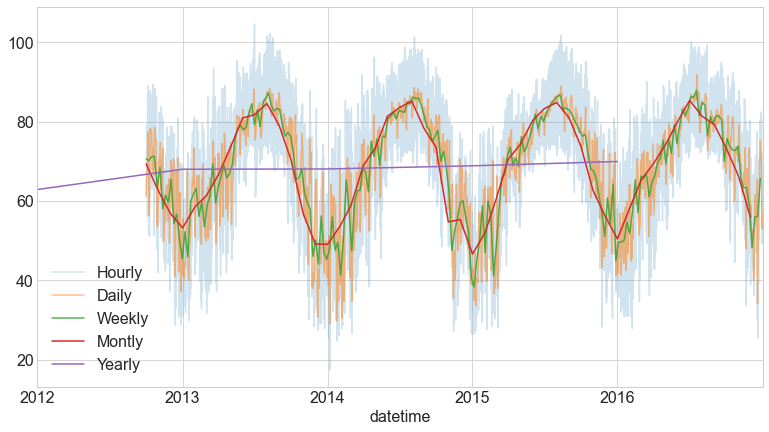

In [21]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().plot(alpha=.5, label='Daily')
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

In [22]:
y.resample('Y').mean()

datetime
2012-12-31    62.866222
2013-12-31    67.983753
2014-12-31    68.050553
2015-12-31    68.844987
2016-12-31    69.932853
Freq: A-DEC, Name: temp, dtype: float64

In addition to resampling, we can calculate moving averages with the `.rolling` method.

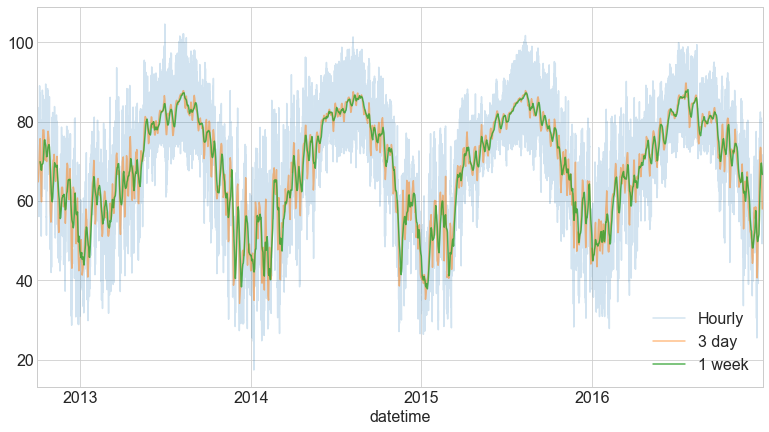

In [23]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().rolling(3).mean().plot(alpha=.5, label='3 day')
y.resample('D').mean().rolling(7).mean().plot(alpha=.8, label='1 week')
plt.legend()

### Visualizing Volatility
`.diff` let's us take the difference between the current and previous value

<AxesSubplot:title={'center':'Hourly Difference in Temperature'}, xlabel='datetime'>

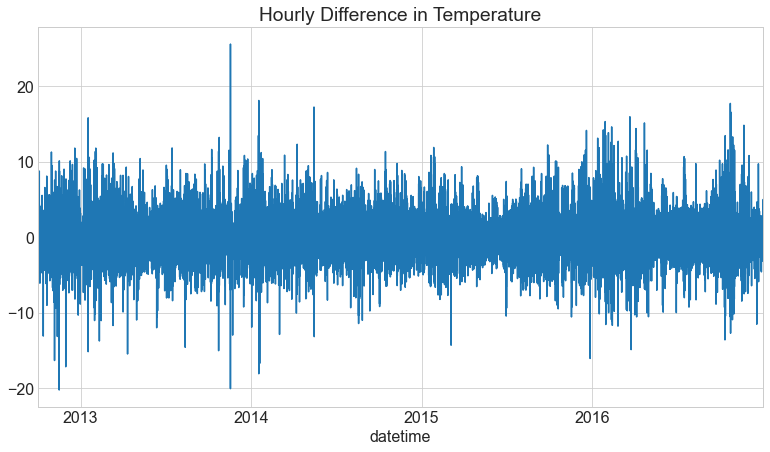

In [24]:
y.diff().plot(title='Hourly Difference in Temperature')

This is a pretty noisy plot. Its difficult to make anything out. Perhaps looking at % change might give us more insight?

In [25]:
y

datetime
2012-10-01 13:00:00    61.052000
2012-10-01 14:00:00    61.076568
2012-10-01 15:00:00    61.139294
2012-10-01 16:00:00    61.202020
2012-10-01 17:00:00    61.264747
                         ...    
2016-12-31 19:00:00    63.230000
2016-12-31 20:00:00    68.216000
2016-12-31 21:00:00    70.664000
2016-12-31 22:00:00    71.348000
2016-12-31 23:00:00    71.600000
Name: temp, Length: 37259, dtype: float64

In [26]:
y.diff()

datetime
2012-10-01 13:00:00         NaN
2012-10-01 14:00:00    0.024568
2012-10-01 15:00:00    0.062726
2012-10-01 16:00:00    0.062726
2012-10-01 17:00:00    0.062726
                         ...   
2016-12-31 19:00:00    4.752000
2016-12-31 20:00:00    4.986000
2016-12-31 21:00:00    2.448000
2016-12-31 22:00:00    0.684000
2016-12-31 23:00:00    0.252000
Name: temp, Length: 37259, dtype: float64

In [27]:
y.shift()

datetime
2012-10-01 13:00:00          NaN
2012-10-01 14:00:00    61.052000
2012-10-01 15:00:00    61.076568
2012-10-01 16:00:00    61.139294
2012-10-01 17:00:00    61.202020
                         ...    
2016-12-31 19:00:00    58.478000
2016-12-31 20:00:00    63.230000
2016-12-31 21:00:00    68.216000
2016-12-31 22:00:00    70.664000
2016-12-31 23:00:00    71.348000
Name: temp, Length: 37259, dtype: float64

<AxesSubplot:title={'center':'Hourly % Change in Temperature'}, xlabel='datetime'>

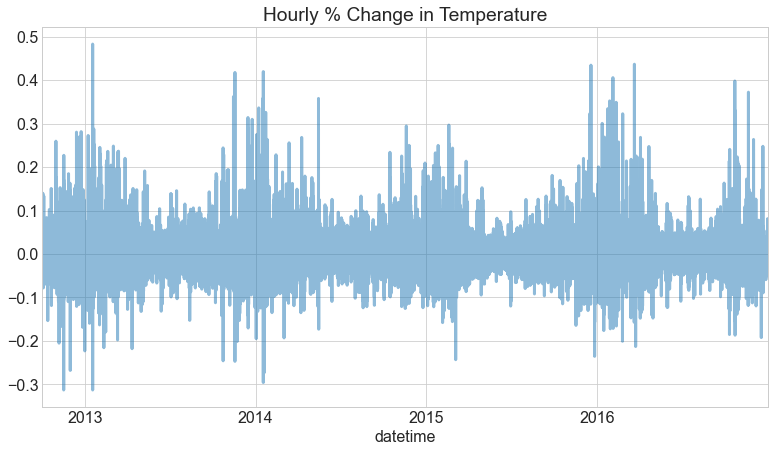

In [28]:
(y.diff() / y.shift()).plot(alpha=.5, lw=3, title='Hourly % Change in Temperature')

Although it's slightly better, we really will need to resample to reduce some of this noise.

In [29]:
y.resample('W').mean().diff()

datetime
2012-10-07          NaN
2012-10-14    -0.442379
2012-10-21     0.985554
2012-10-28     0.092089
2012-11-04    -7.719911
                ...    
2016-12-04    -4.340288
2016-12-11   -10.898468
2016-12-18     7.815506
2016-12-25     0.094012
2017-01-01     9.567482
Freq: W-SUN, Name: temp, Length: 222, dtype: float64

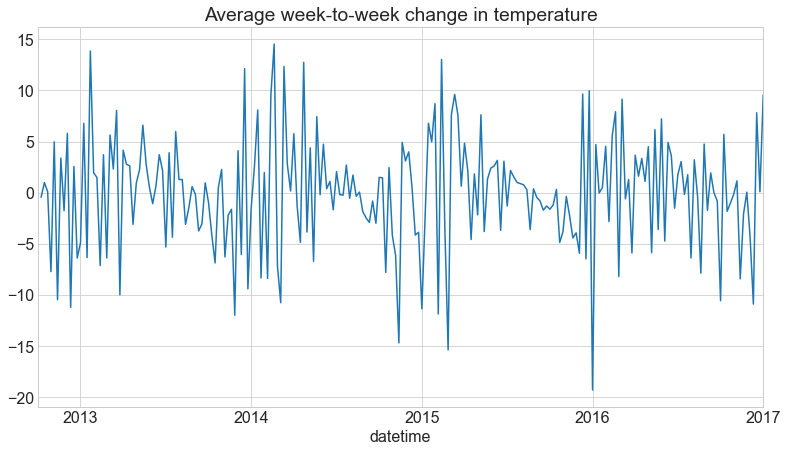

In [30]:
y.resample('W').mean().diff().plot(title='Average week-to-week change in temperature');

<AxesSubplot:title={'center':'Average Week-to-Week % Change in Temperature'}, xlabel='datetime'>

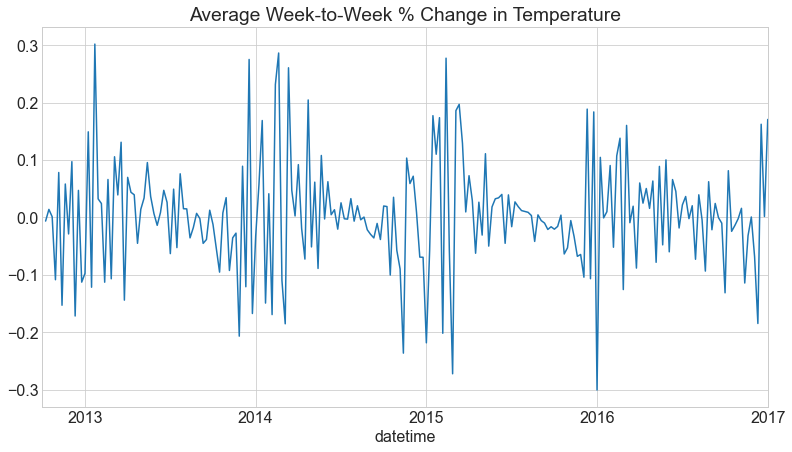

In [31]:
(y.resample('W').mean().diff() / y.resample('W').mean().shift()).plot(title='Average Week-to-Week % Change in Temperature')

In [32]:
y.resample('W').mean().shift()

datetime
2012-10-07          NaN
2012-10-14    70.595201
2012-10-21    70.152821
2012-10-28    71.138375
2012-11-04    71.230464
                ...    
2016-12-04    63.402382
2016-12-11    59.062094
2016-12-18    48.163625
2016-12-25    55.979132
2017-01-01    56.073143
Freq: W-SUN, Name: temp, Length: 222, dtype: float64

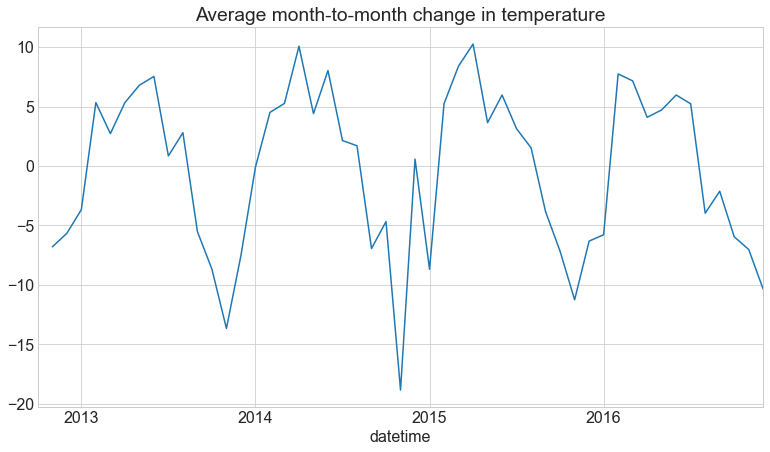

In [33]:
y.resample('M').mean().diff().plot(title='Average month-to-month change in temperature');

<AxesSubplot:title={'center':'Average Month-to-Month % Change in Temperature'}, xlabel='datetime'>

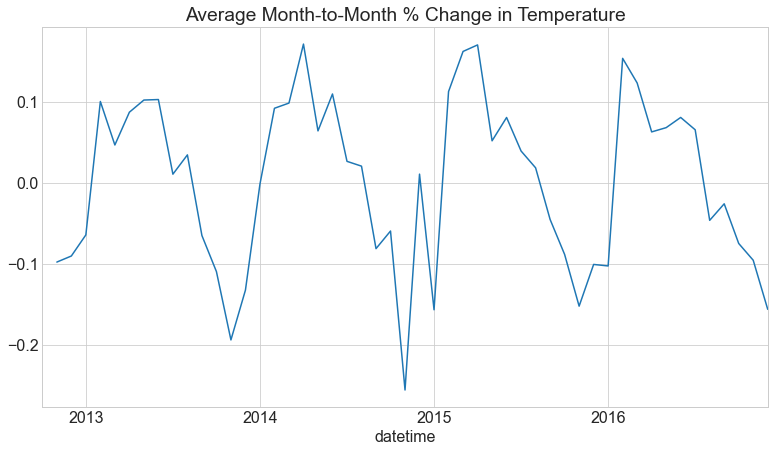

In [34]:
(y.resample('M').mean().diff() / y.resample('M').mean().shift()).plot(title='Average Month-to-Month % Change in Temperature')

### Seasonal Plot
A seasonal plot shows the comparison of multiple seasons together. In this case, our season is one year in length. It is a line plot with the x-axis being the month of the year and the y axis being the target variable. Multiple lines are shown to show multiple years.

In [35]:
# Start off by getting average temperate for each year-month combination:
y.groupby([y.index.year, y.index.month]).mean()

datetime  datetime
2012      10          69.318705
          11          62.521575
          12          56.860014
2013      1           53.192333
          2           58.522799
          3           61.244479
          4           66.569717
          5           73.358529
          6           80.885728
          7           81.731819
          8           84.534117
          9           79.016805
          10          70.343832
          11          56.686028
          12          49.165310
2014      1           49.072897
          2           53.579080
          3           58.842459
          4           68.908933
          5           73.311970
          6           81.337658
          7           83.476876
          8           85.178102
          9           78.238621
          10          73.567252
          11          54.735951
          12          55.311824
2015      1           46.631940
          2           51.874683
          3           60.277705
          4          

In [36]:
# unstack is similar to pivot_table and be used to break up multi-level indices. 
# In this case, we turn the 0 index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0)

datetime,2012,2013,2014,2015,2016
datetime,,,,,
1,NaN,53.192333,49.072897,46.631940,50.427347
2,NaN,58.522799,53.579080,51.874683,58.165749
3,NaN,61.244479,58.842459,60.277705,65.323011
4,NaN,66.569717,68.908933,70.526879,69.415316
5,NaN,73.358529,73.311970,74.169747,74.129780
6,NaN,80.885728,81.337658,80.135967,80.097570
7,NaN,81.731819,83.476876,83.264325,85.325640
8,NaN,84.534117,85.178102,84.789859,81.357023
9,NaN,79.016805,78.238621,80.938208,79.233476


<AxesSubplot:xlabel='datetime'>

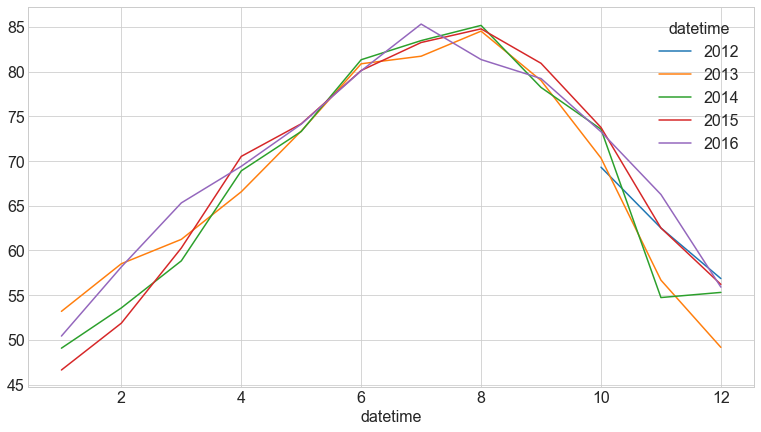

In [37]:
# Run .plot on this object
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot()

### Seasonal Subseries Plot
A seasonal subseries plot shows the change year-over-year within each month.

Do not use this plot as part of presentation! This is for EDA only.

In [38]:
# This is actually the same pivot table as above, but months are on the top and years are on the left
table = y.groupby([y.index.year, y.index.month]).mean().unstack()
table

datetime,1,2,3,4,5,6,7,8,9,10,11,12
datetime,,,,,,,,,,,,
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.318705,62.521575,56.860014
2013,53.192333,58.522799,61.244479,66.569717,73.358529,80.885728,81.731819,84.534117,79.016805,70.343832,56.686028,49.165310
2014,49.072897,53.579080,58.842459,68.908933,73.311970,81.337658,83.476876,85.178102,78.238621,73.567252,54.735951,55.311824
2015,46.631940,51.874683,60.277705,70.526879,74.169747,80.135967,83.264325,84.789859,80.938208,73.766466,62.519181,56.207118
2016,50.427347,58.165749,65.323011,69.415316,74.129780,80.097570,85.325640,81.357023,79.233476,73.284788,66.265047,55.903224


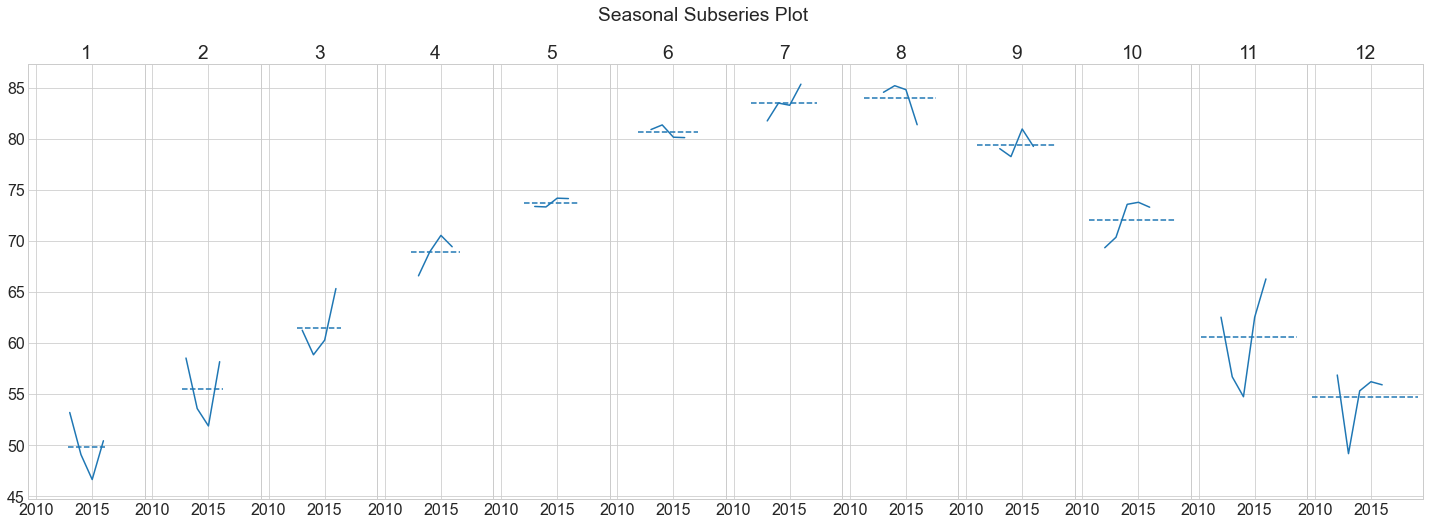

In [78]:
fig, axs = plt.subplots(1, 12, sharey=True, sharex=True, figsize=(25,8))
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    x_left, x_right = ax.get_xlim()
    ax.hlines(subset.mean(), x_left, x_right, ls='--')
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

#### As with the monthly box plot, the seasonal pattern is quite evident in the seasonal subseries.
- Do the data exhibit a seasonal pattern?
- What is the nature of the seasonality?
- Is there a within-group pattern (e.g., do January and July exhibit similar patterns)?
- Are there any outliers once seasonality has been accounted for?
- Should I use box plot instead?

### What if seasonality is not that readily apparent?

Is there a seasonality in this data?

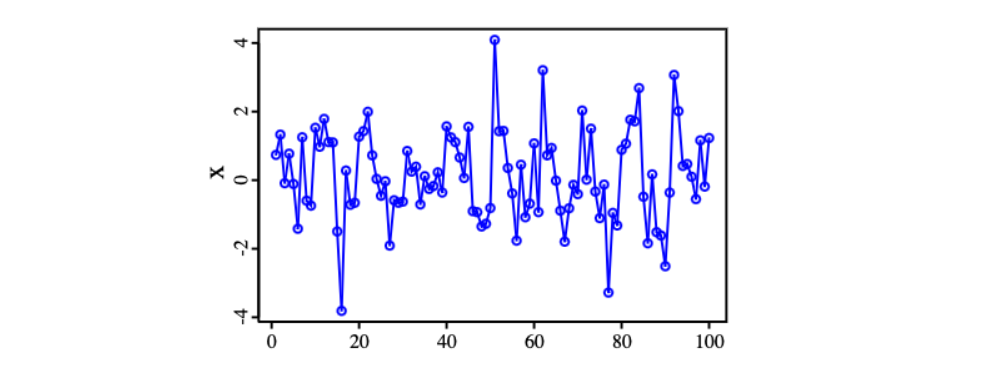

### Lag Plot

A lag plot is a scatter plot of a series with itself, shifted, or lagged. Put another way, a lag plot measures one value against the next or previous value.

If your data is sampled daily, you could think of `t` as 'today', `t+1` is 'tomorrow'. More generally, `t` is any given time period and `t+1` is the time period after. If your data is sampled weekly, `t` is any given week, and `t+1` is the following week.

In [40]:
train['y(t + 1)'] = train.temp.shift(-1)

In [41]:
train

,temp,month,weekday,y(t + 1)
datetime,,,,
2012-10-01 13:00:00,61.052000,10-Oct,Monday,61.076568
2012-10-01 14:00:00,61.076568,10-Oct,Monday,61.139294
2012-10-01 15:00:00,61.139294,10-Oct,Monday,61.202020
2012-10-01 16:00:00,61.202020,10-Oct,Monday,61.264747
2012-10-01 17:00:00,61.264747,10-Oct,Monday,61.327473
...,...,...,...,...
2016-12-31 19:00:00,63.230000,12-Dec,Saturday,68.216000
2016-12-31 20:00:00,68.216000,12-Dec,Saturday,70.664000
2016-12-31 21:00:00,70.664000,12-Dec,Saturday,71.348000


[Text(0.5, 0, 't'), Text(0, 0.5, 't + 1')]

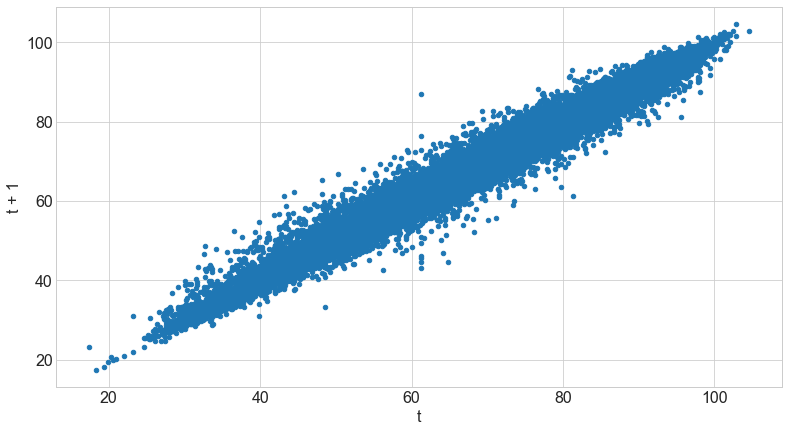

In [42]:
ax = train.plot.scatter(x='temp', y='y(t + 1)')
ax.set(xlabel='t', ylabel='t + 1')

In [43]:
del train['y(t + 1)']

<AxesSubplot:xlabel='temp', ylabel='temp_next_day'>

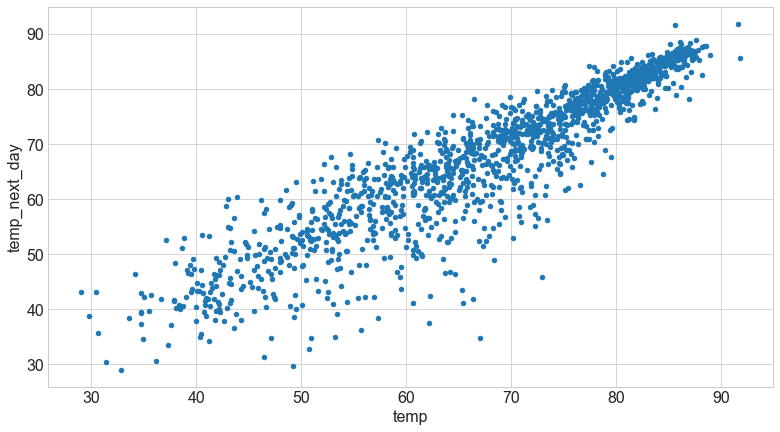

In [44]:
daily = train.resample('D').mean()
daily['temp_next_day'] = daily.temp.shift(-1)
daily.plot.scatter(x='temp', y='temp_next_day')

In [45]:
weekly = train.resample('W').mean()
weekly['the_next_week'] = weekly.temp.shift(-1)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.head()

,this_week,the_next_week
datetime,,
2012-10-07,70.595201,70.152821
2012-10-14,70.152821,71.138375
2012-10-21,71.138375,71.230464
2012-10-28,71.230464,63.510554
2012-11-04,63.510554,68.482625


<AxesSubplot:xlabel='this_week', ylabel='the_next_week'>

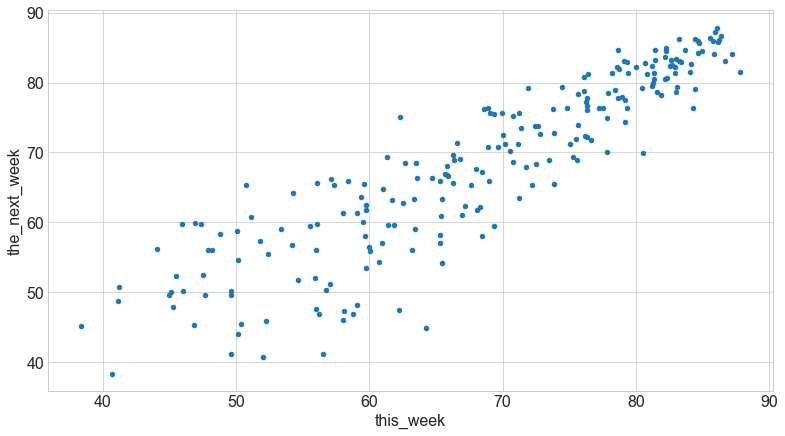

In [46]:
weekly.plot.scatter(x='this_week', y='the_next_week')

,this_week,12_weeks_out
datetime,,
2012-10-07,70.595201,50.376741
2012-10-14,70.152821,45.473616
2012-10-21,71.138375,52.252877
2012-10-28,71.230464,45.907936
2012-11-04,63.510554,59.763739


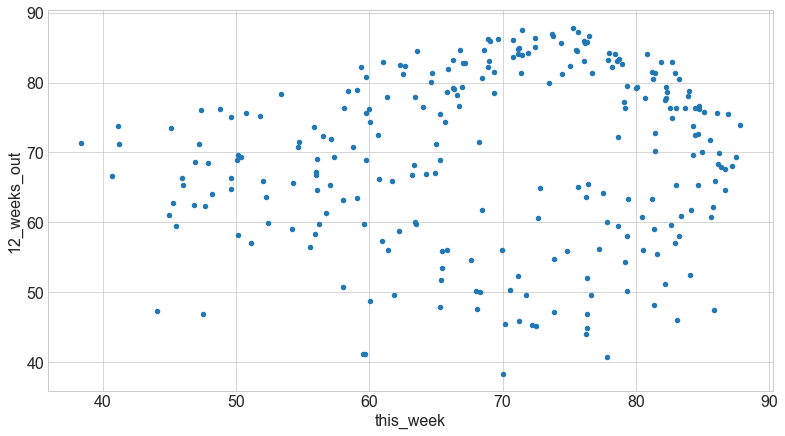

In [47]:
weekly = df.resample('W').mean()
weekly['12_weeks_out'] = weekly.temp.shift(-12)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='12_weeks_out')
weekly.head()

,this_week,26_weeks_out
datetime,,
2012-10-07,70.595201,63.558611
2012-10-14,70.152821,66.345532
2012-10-21,71.138375,68.965502
2012-10-28,71.230464,65.862071
2012-11-04,63.510554,66.797107


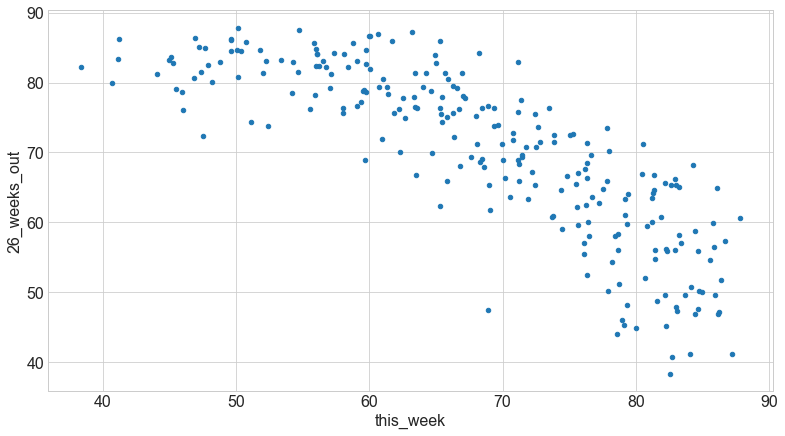

In [48]:
weekly = df.resample('W').mean()
weekly['26_weeks_out'] = weekly.temp.shift(-26)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='26_weeks_out')
weekly.head()

Note that pandas has a built in `lag_plot()` function that can do some of the work for us:

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 26)'>

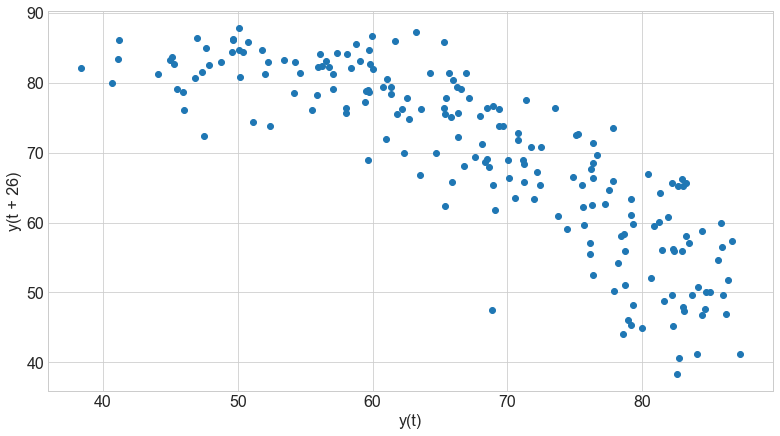

In [49]:
# easier way. Use pd.plotting.lag_plot(series, lag):m
pd.plotting.lag_plot(train.temp.resample('W').mean(), lag=26)

### Autocorrelation Plot
**Autocorrelation** is a measure of the linear relationship between lagged values of a time series. An autocorrelation plot shows the correlation coefficient as a function of lag time.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

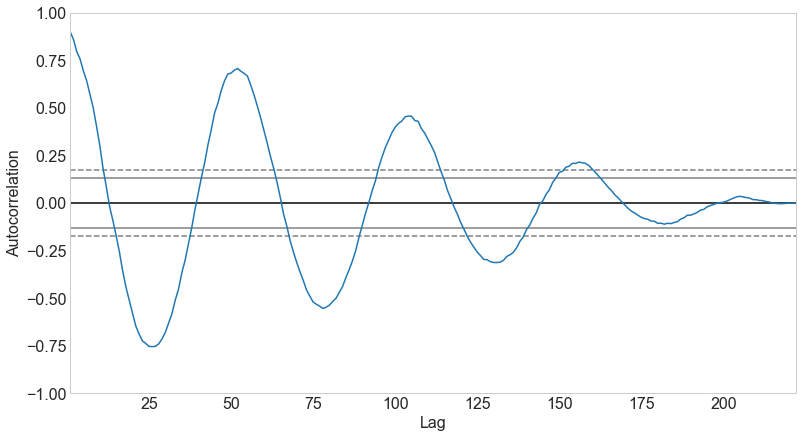

In [50]:
pd.plotting.autocorrelation_plot(train.temp.resample('W').mean())

This can help us identify seasonality by looking at the peaks and valleys of the resulting visualization. The peaks can tells us the frequency with which the seasonality repeats itself, and the valleys show us where the correlation is the most negative.

The dashed lines are a way measure whether the observed autocorrelation is a meaningful signal or just white noise. If the majority of the peaks and valleys fall within the dashed lines, the time series is probably white noise.

### What does autocorrelation look like for white noise?

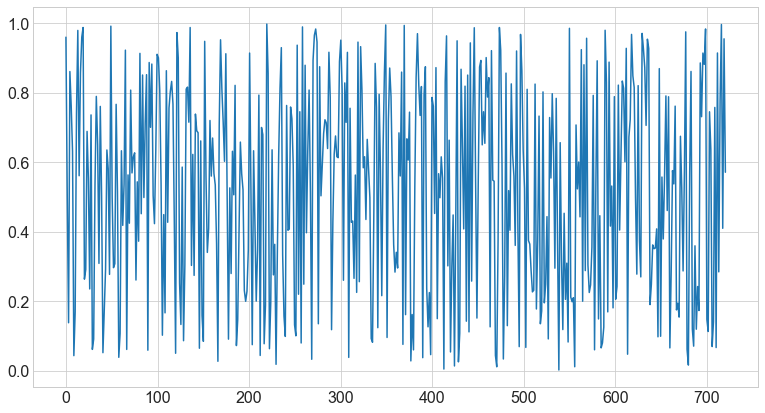

In [79]:
grid = np.linspace(0, 720, 500)
noise = np.random.rand(500)
# result_curve =  noise
plt.plot(grid, noise)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

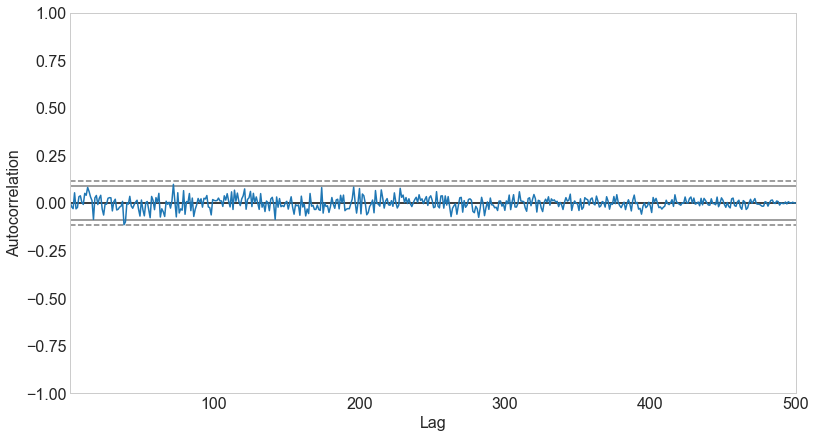

In [80]:
#plot the autocorrelation for noise

pd.plotting.autocorrelation_plot(noise)

### Seasonal Decomposition

Seasonal decomposition is a fancy way to say that we can model time series as having 3 seperate components, the seasonal repeated cycle, the long term trend, and random noise1. There are two types of seasonal decomposition models, additive and multiplicative.

$$ y = S + T + \epsilon $$

### data = Seasonality + Trend + Residual

In [53]:
y = train.temp.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
result

In [54]:
# we can access different attributes of object created above (e.g. seasonal, trend and resid)
result.seasonal

datetime
2012-10-07     8.545501
2012-10-14     7.255470
2012-10-21     2.468309
2012-10-28     1.820126
2012-11-04    -0.114287
                ...    
2016-12-04   -14.650102
2016-12-11   -13.263237
2016-12-18   -12.765114
2016-12-25   -13.857895
2017-01-01   -24.587601
Freq: W-SUN, Name: seasonal, Length: 222, dtype: float64

In [55]:
# Make a dataframe:

decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
datetime,,,,
2012-10-07,70.595201,NaN,8.545501,NaN
2012-10-14,70.152821,NaN,7.255470,NaN
2012-10-21,71.138375,NaN,2.468309,NaN
2012-10-28,71.230464,NaN,1.820126,NaN
2012-11-04,63.510554,NaN,-0.114287,NaN


In [56]:
decomposition.tail()

,y,trend,seasonal,resid
datetime,,,,
2016-12-04,59.062094,NaN,-14.650102,NaN
2016-12-11,48.163625,NaN,-13.263237,NaN
2016-12-18,55.979132,NaN,-12.765114,NaN
2016-12-25,56.073143,NaN,-13.857895,NaN
2017-01-01,65.640625,NaN,-24.587601,NaN


<AxesSubplot:xlabel='datetime'>

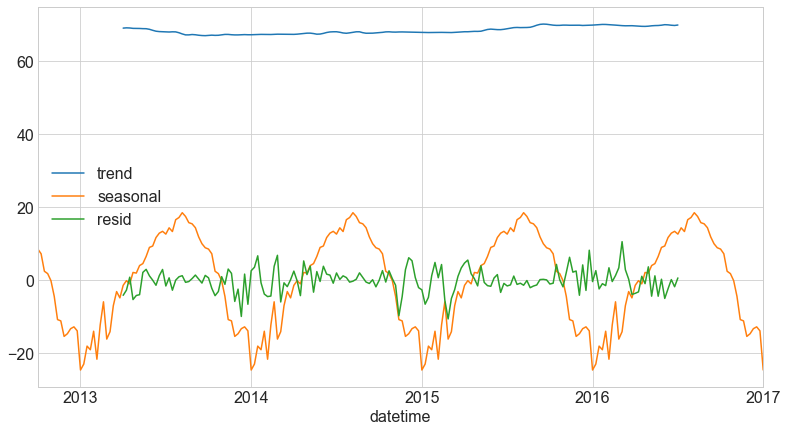

In [57]:
decomposition.iloc[:, 1:].plot()

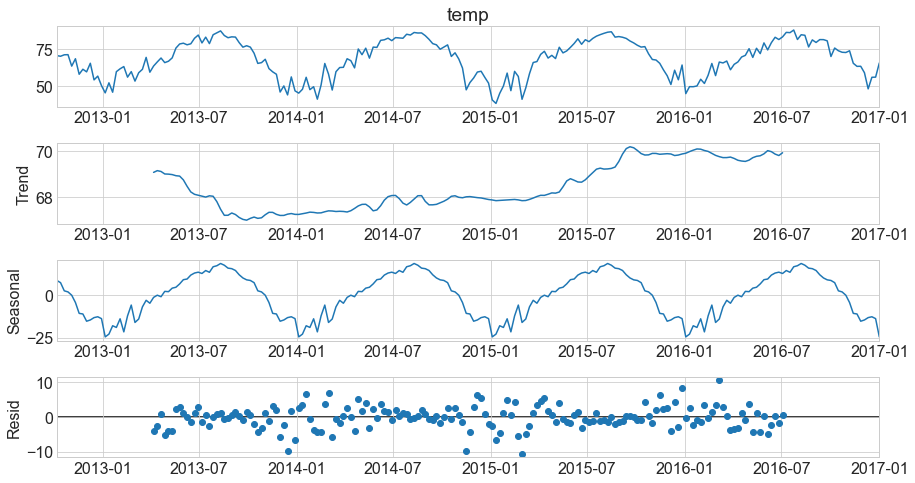

In [58]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None

### Additive or multiplicative seasonality?


The additive model is most appropriate if the magnitude of the seasonal fluctuations or the variation around the trend-cycle does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative model is more appropriate. 


https://kourentzes.com/forecasting/2014/11/09/additive-and-multiplicative-seasonality/

Effectively, with multiplicative seasonality the width of the seasonal pattern is proportional to the level. For additive seasonality it is independent.

### Categories Over Time

In [59]:
train = train.resample('D').mean()
train.head()

,temp
datetime,
2012-10-01,61.330942
2012-10-02,65.678822
2012-10-03,67.411250
2012-10-04,67.703750
2012-10-05,77.073125


In [60]:
# create a categorical feature
train['temp_bin'] = pd.qcut(train.temp, 4, labels=['cold', 'cool', 'warm', 'hot'])
train.groupby('temp_bin').temp.mean()

temp_bin
cold    49.381699
cool    65.200219
warm    75.447977
hot     83.449087
Name: temp, dtype: float64

In [61]:
train.head()

,temp,temp_bin
datetime,,
2012-10-01,61.330942,cool
2012-10-02,65.678822,cool
2012-10-03,67.411250,cool
2012-10-04,67.703750,cool
2012-10-05,77.073125,warm


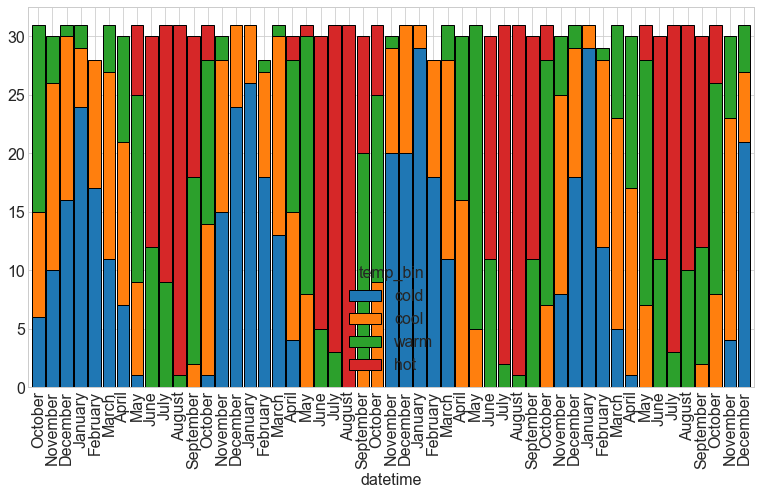

In [62]:
ax = (train.groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black')
)
# take the existing labels, convert them to Timestamps, and then reformat with .strftime
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels);

##### A recent example
https://coronavirus.health.ny.gov/covid-19-variant-data

Text(0, 0.5, '% of days in the month')

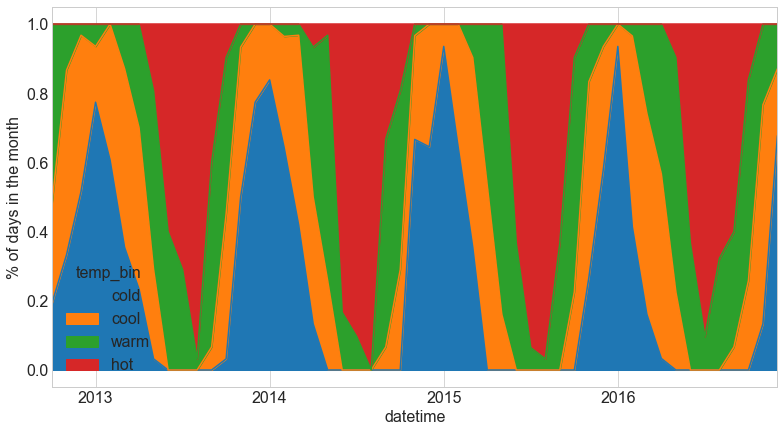

In [63]:
(train.groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.ylabel('% of days in the month')

[Text(0, 0, 'January'),
 Text(1, 0, 'February'),
 Text(2, 0, 'March'),
 Text(3, 0, 'April'),
 Text(4, 0, 'May'),
 Text(5, 0, 'June'),
 Text(6, 0, 'July'),
 Text(7, 0, 'August'),
 Text(8, 0, 'September'),
 Text(9, 0, 'October'),
 Text(10, 0, 'November'),
 Text(11, 0, 'December')]

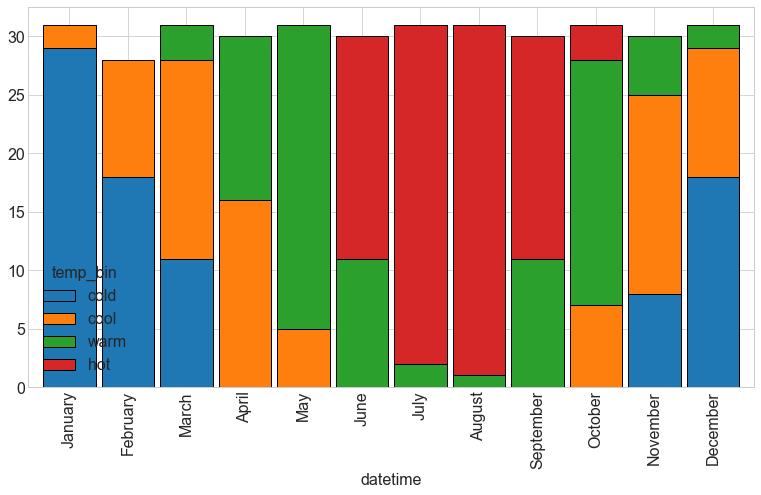

In [64]:
ax = (train['2015']
 .groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black')
)
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels)

### strftime

A common problem we can run into when visualizing time series data is that the order of the months or days of the week logically is not the same as the order alphabetically. One workaround for this is to format the dates such that the have a number prepended to them (for example, 0-sunday, 1-monday) and the plot. Once the plot is created, we can manipulate the tick labels and remove the prefix.

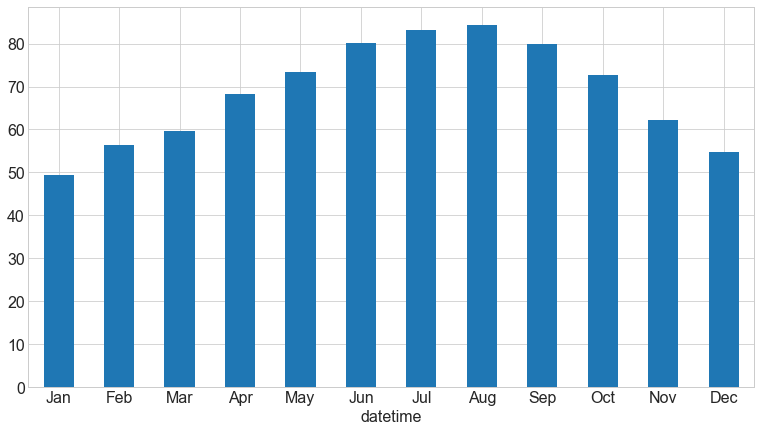

In [65]:
ax = y.groupby(y.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0);
# 01-Jan [3:]

In [66]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

### Matplotlib Dates

This will only work with plt.plot or ax.plot, not with the pandas plotting!

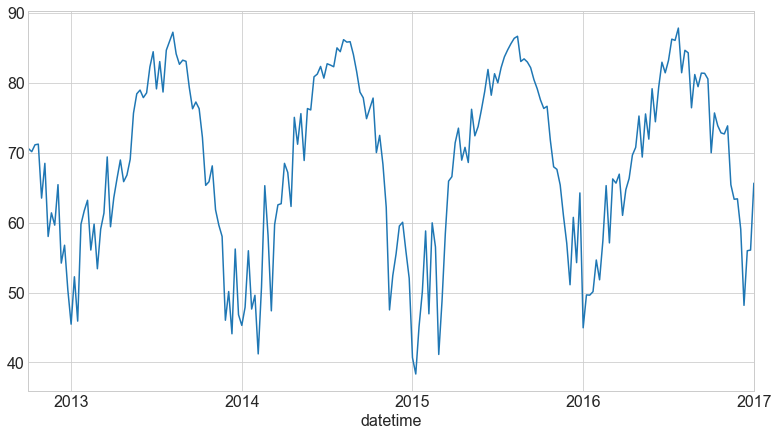

In [67]:
# how can i customize the x axis label here?

y.resample('W').mean().plot()
plt.xticks();

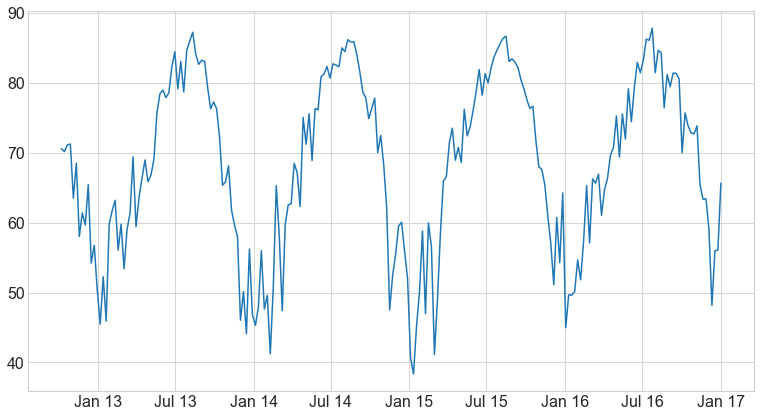

In [68]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()

weekly = y.resample('W').mean()

ax.plot(weekly.index, weekly)

ax.xaxis.set_major_formatter(DateFormatter('%b %y'))

### Exercise
Do your work for this exercise in a notebook named `explore.ipynb`. Use the techniques in the lesson to explore the **store item demand** dataset and the **opsd** dataset.

For the store item demand data, you will need to choose a method of aggregating such that each observation is a unique date. For both datasets you should choose a method of splitting your data and only explore the training split.

**Note: When resampling data, use a `mean()` aggregation method.**

### Store Item Demand
Load your store item demand data using your acquire and/or prepare functions.
1. Using a human-based approach, split your dataset into train and test sets.
2. Visualize your train-test split.

Only use your train data set to perform the following tasks:

3. Resample your data and visualize it.
4. Creating a rolling (moving) average of your data and visualize it.
5. Plot the difference in sales from one day to the next.
6. Plot the % difference in sales from one day to the next.
6. Plot the % difference in sales from one week to the next.
7. Plot the % difference in sales from one month to the next.
8. Visualize an autocorrelation plot on a weekly resampling.
9. Visualize a seasonal decomposition plot on a weekly resampling.

### OPS data
Load your OPS data using your acquire and/or prepare functions.
1. Split the data, so that train contains information up to and including 2013. The remaning data should be placed in test. 

Only use the train data set to perform the following tasks:

2. Visualize your train-test split.
3. Plot the consumption, wind, and solar data on the same chart.
4. Plot only the consumption data from the year 2010. Are there any patterns you can identify? Note them in a markdown section.
5. Resample the consumption data to monthly and plot it.
6. Resample the consumption data to yearly and plot it.

#### BONUS:
7. Group the consumption data by month and create a boxplot treating the month component as a separate categorical feature.
8. Group the consumption data by weekday and create a boxplot treating the weekday component as a separate categorical feature.
9. Create a subseasonal plot by month of your consumption data. 
10. Create one or two visualizations that helps answer the follow questions: How does wind production/consumption vary within a year? How does wind production/consumption vary from year to year?
11. Create one or two visualizations that helps answer the follow questions: How does solar production/consumption vary within a year? How does solar production/consumption vary from year to year?
12. Plot a time series decomposition for your consumption data and note your takeaways.
13. Create an autocorrelation plot of a weekly resampling of the consumption data.